In [1]:
import warnings
warnings.filterwarnings("ignore")
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/home/tguo/tguo2/miniconda3/envs/env_STAligner/lib/R"
os.environ['R_USER'] = "/home/tguo/tguo2/miniconda3/envs/env_STAligner/lib/python3.7/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
from scipy import sparse

import torch
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [20]:
dirs="/data02/tguo/space_batch_effect/mouse_brain/"
Batch_list = []
adj_list = []
section_ids = ['all_posterior1','all_posterior2','all_anterior1','all_anterior2']
section_ids=["all_posterior1","all_posterior2"]
section_ids=["all_anterior1","all_anterior2"]

print(section_ids)

for section_id in section_ids:
    print(section_id)
    count=pd.read_csv(dirs+"gtt_input/"+section_id+"_mat_allgene.csv",sep=',',header=0,index_col=0)
    adata = sc.AnnData(count)
    adata.X=sparse.csr_matrix(adata.X)
    adata.var_names_make_unique(join="++")

    # read the annotation
    meta = pd.read_csv(dirs+"gtt_input/"+section_id+"_meta.csv", sep=',', header=0, index_col=0)
    
    adata.obs['celltype'] = meta.loc[adata.obs_names, 'celltype']
    adata.obs['batch'] = meta.loc[adata.obs_names, 'batch']
    
    coord=pd.read_csv(dirs+"gtt_input/"+section_id+"_coord.csv",header=0,index_col=0,sep=',')
    coord.columns=['x','y']
    
    adata.obsm["spatial"] = coord.to_numpy()
    
    
    
    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, k_cutoff=6,model='Radius',rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['all_anterior1', 'all_anterior2']
all_anterior1
------Calculating spatial graph...
The graph contains 15686 edges, 2696 cells.
5.8182 neighbors per cell on average.
all_anterior2
------Calculating spatial graph...
The graph contains 16456 edges, 2825 cells.
5.8251 neighbors per cell on average.


In [21]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['celltype'] = adata_concat.obs['celltype']
adata_concat.obs["batch_name"] = adata_concat.obs["batch"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (5521, 3462)


In [22]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

In [23]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)
# section_ids = ['all_posterior1','all_posterior2','all_anterior1','all_anterior2']
# section_ids=["posterior1","posterior2"]
section_ids=["anterior1","anterior2"]
flags=''
for i in np.arange(len(section_ids)):
    flags=flags+'_'+str(section_ids[i])
embed=adata_concat.obsm['STAligner']
embed_names=['STAligner-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=adata_concat.obs_names,columns=embed_names)
embed.to_csv(dirs+"methods/STAligner_mat"+flags+'.txt')

STAligner(
  (conv1): GATConv(3462, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 3462, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:16<00:00, 30.24it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|█▉        | 99/500 [00:04<00:13, 30.06it/s]

Update spot triplets at epoch 600


 40%|████      | 200/500 [00:09<00:09, 30.05it/s]

Update spot triplets at epoch 700


 60%|█████▉    | 298/500 [00:14<00:06, 30.08it/s]

Update spot triplets at epoch 800


 80%|███████▉  | 398/500 [00:19<00:03, 30.09it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [00:24<00:00, 20.60it/s]


CPU times: user 44.6 s, sys: 7.17 s, total: 51.8 s
Wall time: 41.6 s


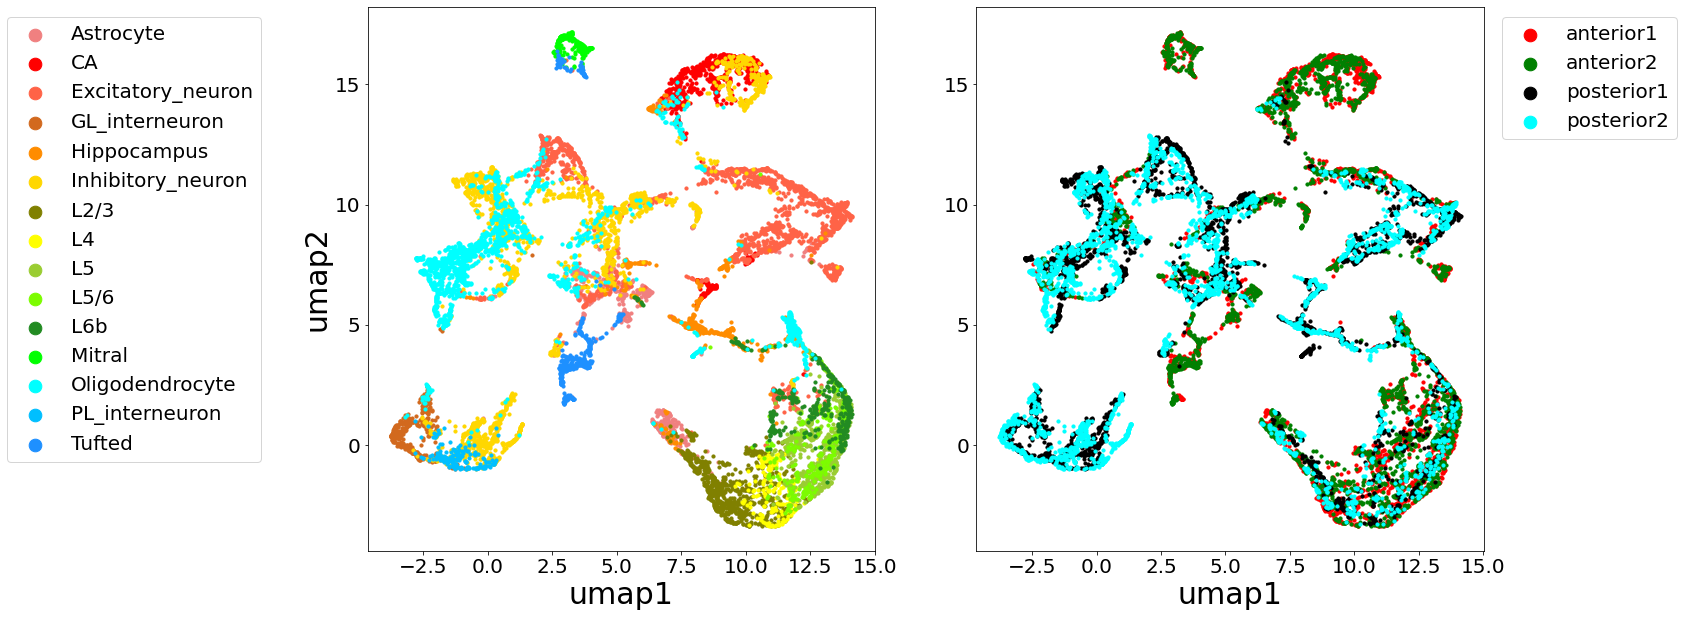

In [24]:
celltype=adata_concat.obs['celltype'].values
batch=adata_concat.obs['batch_name'].values
ul=np.unique(celltype)
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
umap_mat=umap.UMAP().fit_transform(adata_concat.obsm['STAligner'])
# x=PCA(n_components=30).fit_transform(SPII.feat.values)
# umap_mat=umap.UMAP().fit_transform(x)
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']

colour2=['r','g','black','cyan','blue','purple','yellow','grey']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=10
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)